This notebook aims to compare a model built with HARK.ConsumptionSaving tools, and a model built with the GenericModel class.

In [25]:
from HARK.distribution import Lognormal
from HARK.simulation import GenericModel
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
import matplotlib.pyplot as plt
import numpy as np

Recall that the Perfect Foresight equations are as follows:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t}~U(C_t) + \beta \aleph V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
%A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_{t+1}, \\
P_{t+1} &=& \Gamma_{t+1} P_t, \\
\end{eqnarray*}

With the following parameters:


| Param | Description | Code | Value |
| :---: | ---  | --- | :---: |
| $\rho$ | Relative risk aversion | $\texttt{CRRA}$ | 2.5 |
| $\beta$ | Discount factor | $\texttt{DiscFac}$ | 0.96 |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 |
| $\newcommand{\LivFac}{\aleph}\LivFac$ | Survival probability | $\texttt{LivPrb}$ | 0.98 |
| $\Gamma$ | Income growth factor | $\texttt{PermGroFac}$ | 1.01 |


First, let's build and solve the normal perfect foresight model.

In [18]:
# This cell defines a parameter dictionary. You can expand it if you want to see what that looks like.
PF_dictionary = {
    'CRRA' : 2.5,
    'DiscFac' : 0.96,
    'Rfree' : 1.03,
    'LivPrb' : [0.98],
    'PermGroFac' : [1.01],
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount' : 10000
}

pf = PerfForesightConsumerType(**PF_dictionary)
pf.solve()

In [19]:
first_solution(50)

4.147572719602175

To translate this into the GenericModel configuration:

In [20]:
#####
# PerfectForesight
#####

## Note: the solution argument matches the notation in
##       the model configuration, m_
def first_solution(m_):
    ### This is way more complicated than it should be...
    return pf.solution[0].cFunc(m_).tolist()

sample_configuration = {
    'params' : {
        'PermGroFac' : 1.01,
        'Rfree' : 1.03
    },
    'states' : {
    },
    'controls' : {
        'c' : first_solution # consumption.
        # The function is the decision rule.
    },
    'post_states' : {
        'm' : lambda m_, p_, c, Rfree : Rfree * (m_ - c) + p_, #market assets
        'p' : lambda p_, PermGroFac: p_ * PermGroFac # income
    },
    'initial_states' : {
        'p_' : 1,
        'm_' : 1
    }
}

# 'CRRA' : 2.5       - These are used in utility and value function derivations
#'DiscFac' : 0.96    - these are not yet supported for GenericModel

# 'LivPrb' : [0.98]  - Mortality not yet built into the model

The GenericModel is used just like the other HARK AgentTypes with respect to how simulations are simulated and ran.

In [21]:
generic_model_test = GenericModel(sample_configuration)
generic_model_test.initializeSim()
generic_model_test.simulate()

History is available for the simulated values. All the model variables are tracked.

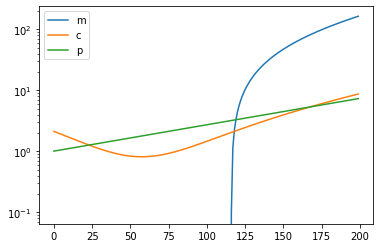

In [22]:
plt.plot(generic_model_test.agent.history['m'], label='m')
plt.plot(generic_model_test.agent.history['c'], label='c')
plt.plot(generic_model_test.agent.history['p'], label='p')
plt.yscale('log')
plt.legend()

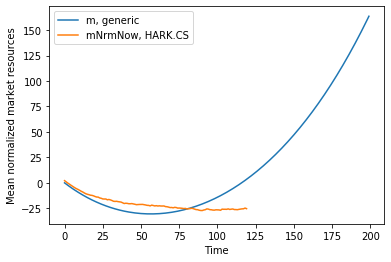

In [31]:
SimulationParams = {
    "AgentCount" : 100,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : 0.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 0.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.01,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

pf(**SimulationParams)

pf.track_vars = ['mNrmNow']
pf.initializeSim()
pf.simulate()


# Plot market resources over time
plt.plot(generic_model_test.agent.history['m'], label='m, generic')
plt.plot(np.mean(pf.mNrmNow_hist,axis=1), label="mNrmNow, HARK.CS")
plt.xlabel('Time')
plt.ylabel('Mean normalized market resources')
plt.legend()
plt.show()